In [58]:
# %% [code]
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

DEBUG_MODE = False  # если True, отладочные сообщения будут выводиться через print

# Таблица ядерных моделей с определением дифференциальной и интегральной форм
NUC_MODELS_TABLE = {
    "F1/3": {"differential_form": lambda e: (3 / 2) * e ** (1 / 3), "integral_form": lambda e: 1 - e ** (2 / 3)},
    "F3/4": {"differential_form": lambda e: 4 * e ** (3 / 4),         "integral_form": lambda e: 1 - e ** (1 / 4)},
    "F3/2": {"differential_form": lambda e: 2 * e ** (3 / 2),         "integral_form": lambda e: e ** (-1 / 2) - 1},
    "F2":   {"differential_form": lambda e: e ** 2,                   "integral_form": lambda e: e ** (-1) - 1},
    "F3":   {"differential_form": lambda e: e ** 3,                   "integral_form": lambda e: e ** (-2) - 1},
    "F1/A1": {"differential_form": lambda e: e,                      "integral_form": lambda e: -np.log(e)},
    "A2":   {"differential_form": lambda e: 2 * e * (-np.log(e)) ** (1 / 2), "integral_form": lambda e: (-np.log(e)) ** (1 / 2)},
    "A3":   {"differential_form": lambda e: 3 * e * (-np.log(e)) ** (2 / 3), "integral_form": lambda e: (-np.log(e)) ** (1 / 3)},
}

# Функция для создания правой части системы ОДУ с отладкой через print
def ode_func_factory(x_params, species_list, reaction_pairs, num_species, num_reactions):
    num_r = num_reactions
    logA = np.array(x_params[0:num_r])
    Ea = np.array(x_params[num_r:2*num_r])
    model_params = np.array(x_params[2*num_r:3*num_r])
    R = 8.314  # универсальная газовая постоянная
    from_indices = np.array([species_list.index(frm) for frm, _ in reaction_pairs])
    to_indices   = np.array([species_list.index(to_) for _, to_ in reaction_pairs])
    Ai = 10 ** logA
    allowed_models = ["F1/3", "F3/4", "F3/2", "F2", "F3"]
    call_count = [0]  # счетчик вызовов для отладки

    def ode_func(T, X, beta):
        call_count[0] += 1
        dXdt = np.zeros_like(X)
        conc = X[0:num_species]
        beta_SI = beta / 60.0  # перевод β в СИ
        ki = (Ai * np.exp(-Ea / (R * T))) / beta_SI
        conc_from = np.maximum(conc[from_indices], 0.0)
        ri = np.zeros_like(ki)
        for i in range(num_r):
            model_index = int(np.clip(round(model_params[i]), 0, len(allowed_models) - 1))
            model_key = allowed_models[model_index]
            model_func = NUC_MODELS_TABLE[model_key]["differential_form"]
            ri[i] = ki[i] * model_func(conc_from[i])
        np.subtract.at(dXdt, from_indices, ri)
        np.add.at(dXdt, to_indices, ri)
        dXdt[num_species:num_species + num_r] = ri  # сохраняем мгновенные скорости реакций

        if DEBUG_MODE and call_count[0] <= 5:
            print(f"ODE call {call_count[0]}: T={T:.2f}, beta={beta}")
            print("X (концентрации и др.):", X)
            print("Concentrations (используемые для реакции):", conc_from)
            print("ki:", ki)
            print("ri (скорости реакций):", ri)
            print("dXdt:", dXdt)
        return dXdt

    return ode_func

# Функции для генерации ОДУ-системы по заданной схеме и извлечения пар реакций
def generate_ode_system(scheme: dict) -> dict:
    nodes = [n["id"] for n in scheme["nodes"]]
    outgoing = {node: [] for node in nodes}
    incoming = {node: [] for node in nodes}
    for edge in scheme["edges"]:
        src = edge["from"]
        dst = edge["to"]
        outgoing[src].append(dst)
        incoming[dst].append(src)
    equations = {}
    for node in nodes:
        cons_terms = [f"k_{node}_{to_} * [{node}]" for to_ in outgoing[node]]
        form_terms = [f"k_{frm}_{node} * [{frm}]" for frm in incoming[node]]
        consumption = " + ".join(cons_terms) if cons_terms else "0"
        formation   = " + ".join(form_terms)   if form_terms else "0"
        eq = f"{formation} - ({consumption})"
        equations[node] = eq
    return equations

def extract_reactions_from_ode_system(ode_system: dict) -> list:
    reaction_pairs = []
    for _, expr in ode_system.items():
        tokens = expr.replace("(", "").replace(")", "").replace("-", "+").split("+")
        for token in tokens:
            token = token.strip()
            if "k_" in token:
                part = token.split("*")[0].strip()
                pieces = part.split("_")
                if len(pieces) == 3:
                    _, frm, to_ = pieces
                    reaction_pairs.append((frm, to_))
    return list(set(reaction_pairs))

# Функция для симуляции системы и вычисления модельной массы (накопленной реакции)
def simulate_model(ode_func, beta, exp_temp, exp_mass, num_species, num_reactions, X_manual):
    X0 = np.zeros(num_species + num_reactions)
    X0[0] = 1.0  # начальная концентрация компонента A
    sol = solve_ivp(lambda T, vec: ode_func(T, vec, beta),
                    [exp_temp[0], exp_temp[-1]],
                    X0,
                    t_eval=exp_temp,
                    method="RK45")
    if not sol.success:
        print("Ошибка интегрирования ОДУ!")
        raise RuntimeError("Интегрирование ОДУ не удалось")
    ints = sol.y[num_species: num_species+num_reactions, :]  # интегрированные скорости реакций
    contributions = X_manual[3*num_reactions:4*num_reactions]
    int_sum = np.sum(contributions[:, np.newaxis] * ints, axis=0)
    M0 = exp_mass[0]
    Mfin = exp_mass[-1]
    model_mass = M0 - (M0 - Mfin) * int_sum
    print(f"simulate_model: beta={beta}, final T={sol.t[-1]}, final X={sol.y[:, -1]}")
    return sol.t, model_mass

# Функция для построения графика сравнения модельной массы с экспериментом
def plot_model_vs_experiment(X_manual, betas, exp_temperature, all_exp_masses, species_list, reaction_pairs, num_species, num_reactions):
    ode_func = ode_func_factory(X_manual[:3*num_reactions], species_list, reaction_pairs, num_species, num_reactions)
    plt.figure(figsize=(6, 4))
    for i, beta in enumerate(betas):
        t_sim, model_mass = simulate_model(ode_func, beta, exp_temperature, all_exp_masses[i], num_species, num_reactions, X_manual)
        plt.plot(t_sim, model_mass, label=f"Модель, β = {beta}")
        plt.scatter(exp_temperature, all_exp_masses[i], s=10, label=f"Эксперимент, β = {beta}")
    plt.xlabel("Температура (K)")
    plt.ylabel("Масса")
    plt.title("Сравнение модельной массы с экспериментом")
    plt.legend()
    plt.grid(True)
    plt.show()

# Новая функция для построения графика, отображающего текущие концентрации компонентов
# (т.е. A, B, C, D) по температуре для каждого β
def plot_component_concentrations(X_manual, betas, exp_temperature, species_list, reaction_pairs, num_species, num_reactions):
    new_df = pd.DataFrame({"temperature": exp_temperature})
    ode_func = ode_func_factory(X_manual[:3*num_reactions], species_list, reaction_pairs, num_species, num_reactions)
    n_beta = len(betas)
    fig, axs = plt.subplots(n_beta, 1, figsize=(6, 4*n_beta), sharex=True)
    if n_beta == 1:
        axs = [axs]
    for i, beta in enumerate(betas):
        X0 = np.zeros(num_species + num_reactions)
        X0[0] = 1.0
        sol = solve_ivp(lambda T, vec: ode_func(T, vec, beta),
                        [exp_temperature[0], exp_temperature[-1]],
                        X0,
                        t_eval=exp_temperature,
                        method="RK45")
        if not sol.success:
            print(f"Ошибка интегрирования для β = {beta}")
            raise RuntimeError("Интегрирование ОДУ не удалось")
        # sol.y[0:num_species] содержат концентрации компонентов (A, B, C, D)
        for j in range(num_species):
            new_df[f"beta_{beta}_component_{species_list[j]}"] = sol.y[j, :]
            axs[i].plot(sol.t, sol.y[j, :], label=f"Концентрация {species_list[j]}")
        axs[i].set_xlabel("Температура (K)")
        axs[i].set_ylabel("Концентрация")
        axs[i].set_title(f"β = {beta}")
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()
    return new_df

# Задаём схему реакций с добавлением направления C → D
scheme = {
    "nodes": [
        {"id": "A"},
        {"id": "B"},
        {"id": "C"},
        {"id": "D"}
    ],
    "edges": [
        {"from": "A", "to": "B"},
        {"from": "B", "to": "C"},
        {"from": "C", "to": "D"}
    ]
}

ode_system = generate_ode_system(scheme)
reaction_pairs = extract_reactions_from_ode_system(ode_system)
species_list = list(ode_system.keys())
num_species = len(species_list)
num_reactions = len(reaction_pairs)
print(f"Схема: species = {species_list}, reaction_pairs = {reaction_pairs}")

# Задаём значения β и экспериментальные массы для каждого эксперимента
betas = [3.0, 5.0, 10.0]
experiment_mass = [1, 1, 1]

# Путь к CSV-файлу с экспериментальными данными
csv_path = r"C:\IDE\repository\solid-state_kinetics\resources\NH4_parse_TGA.csv"
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print("Файл не найден. Используются синтетические данные для демонстрации.")
    temperature = np.linspace(25, 300, 100)
    df = pd.DataFrame({
        "temperature": temperature,
        "rate_3": np.linspace(0, 100, 100),
        "rate_5": np.linspace(0, 100, 100),
        "rate_10": np.linspace(0, 100, 100)
    })

for col in ["temperature", "rate_3", "rate_5", "rate_10"]:
    if col not in df.columns:
        raise ValueError(f"Отсутствует столбец: {col}")

df["Temperature_K"] = df["temperature"] + 273.15
exp_temperature = df["Temperature_K"].values
exp_mass_3 = df["rate_3"].values / 100.0 * experiment_mass[0]
exp_mass_5 = df["rate_5"].values / 100.0 * experiment_mass[1]
exp_mass_10 = df["rate_10"].values / 100.0 * experiment_mass[2]
all_exp_masses = [exp_mass_3, exp_mass_5, exp_mass_10]

print("Данные и функции загружены.")


Схема: species = ['A', 'B', 'C', 'D'], reaction_pairs = [('B', 'C'), ('A', 'B'), ('C', 'D')]
Данные и функции загружены.


simulate_model: beta=3.0, final T=771.33635, final X=[ 2.07760844e-08  3.48979335e-03 -3.63107735e-06  9.96513817e-01
  9.96510186e-01  9.99999979e-01  9.96513817e-01]
simulate_model: beta=5.0, final T=771.33635, final X=[ 5.77216673e-08  4.50634115e-03 -2.66390177e-06  9.95496265e-01
  9.95493601e-01  9.99999942e-01  9.95496265e-01]
simulate_model: beta=10.0, final T=771.33635, final X=[ 2.31011625e-07  6.37686941e-03 -1.52225782e-06  9.93624422e-01
  9.93622900e-01  9.99999769e-01  9.93624422e-01]


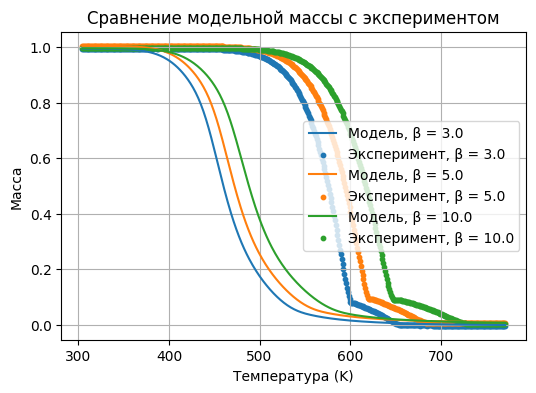

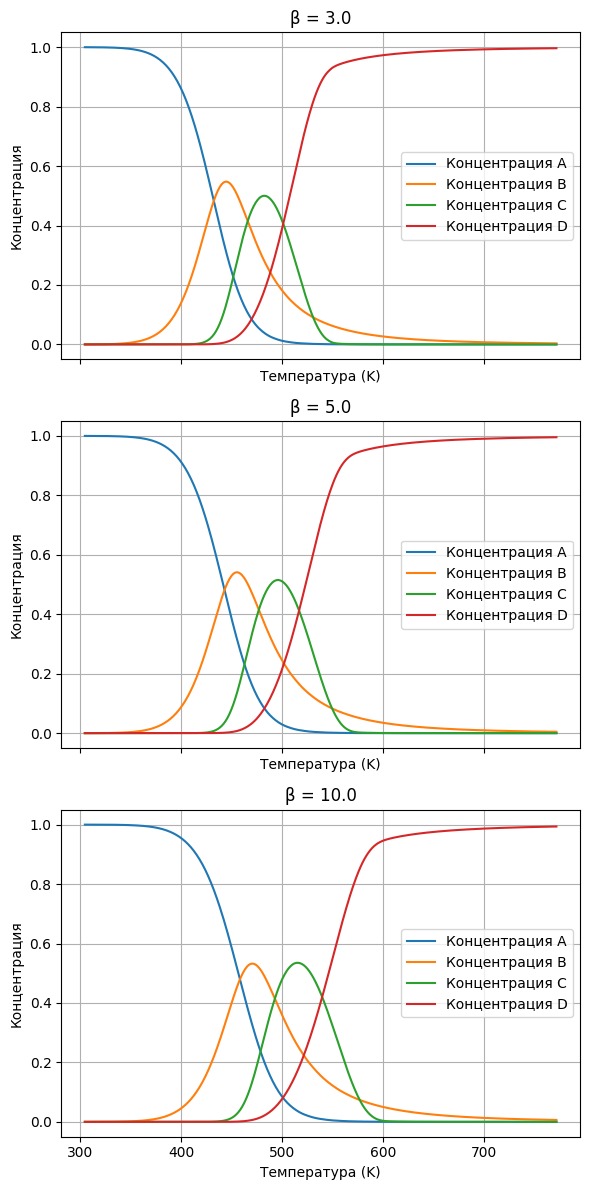

In [120]:
# %% [code]
import numpy as np

# Задаём ручные параметры.
# Для трёх реакций в векторе X_manual должны быть:
# - logA: 3 значения
# - Ea: 3 значения
# - model_params: 3 значения (индексы выбранных моделей, например, 0 соответствует "F1/3", 1 – "F3/4" и т.д.)
# - вклады (contributions): 3 значения, сумма которых равна 1
X_manual = np.array([
    7.0, 5.5, 2.8,             # logA для 3 реакций
    80000.0, 70000.0, 60000.0,   # Ea для 3 реакций
    7, 2, 1,                   # model_params (например, "F1/3", "F3/4", "F1/3")
    0.6, 0.3, 0.1              # вклады (contributions), сумма = 1
])

# График 1: сравнение модельной массы с экспериментальными данными
plot_model_vs_experiment(X_manual, betas, exp_temperature, all_exp_masses, species_list, reaction_pairs, num_species, num_reactions)

# График 2: отображение концентраций компонентов (A, B, C, D) по температуре для каждого β
df = plot_component_concentrations(X_manual, betas, exp_temperature, species_list, reaction_pairs, num_species, num_reactions)


<Axes: >

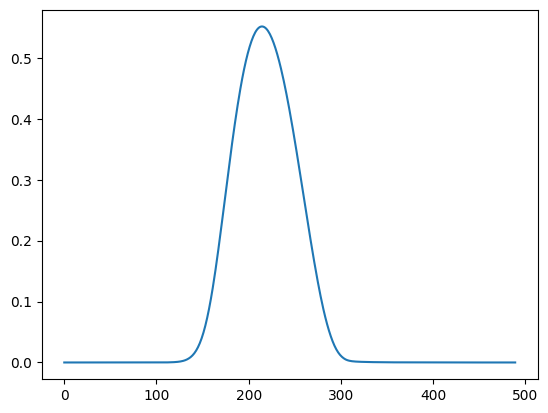

In [102]:
_df = df.loc[:, df.columns != "temperature"].copy()

_df["beta_10.0_component_C"].plot()